# Projeto - parte 1: análise espacial de pontos
## Análise da distribuição de espaços culturais e de entretenimento na cidade de São Paulo 
#### Nicolas Byung Kwan Cho
---
Engloba no escopo da análise locais como bibliotecas, museus, teatro/cinema/shows e espaços culturais



### Instalando e importando bibliotecas 

In [ ]:
!pip install geopandas geopy pointpats fiona pygeos contextily --quiet

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 1.8 MB 40.9 MB/s 
     |████████████████████████████████| 6.3 MB 44.8 MB/s 
     |████████████████████████████████| 2.4 MB 39.8 MB/s 
     |████████████████████████████████| 56.1 MB 31 kB/s 
     |████████████████████████████████| 19.3 MB 75 kB/s 


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import geopandas as gpd 
import seaborn as sns 
import contextily
import itertools 
from matplotlib.patches import Ellipse 
import math


from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
from pointpats import PointPattern
import pointpats.quadrat_statistics as qs
from pointpats.distance_statistics import G, F, K, Genv, Fenv, Kenv
from pointpats import PoissonPointProcess

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Leitura e visualização dos dados

In [ ]:
museus = gpd.read_file('SIRGAS_SHP_TEMA_-_CULTURA_MUSEUS.shp')
tcs = gpd.read_file('SIRGAS_SHP_TEMA_-_CULTURA_TEATRO-CINEMA-SHOW.shp')
bibliotecas = gpd.read_file('SIRGAS_SHP_TEMA_-_CULTURA_BIBLIOTECAS.shp')
esp_culturais = gpd.read_file('SIRGAS_SHP_TEMA_-_CULTURA_ESPACOS_CULTURAIS.shp')

#limites municipais
municipios = gpd.read_file('SIRGAS_limites_municipais.shp')
municipios = municipios.set_crs('EPSG:31983')

In [ ]:
muni_museus = gpd.sjoin(municipios,museus, op='contains')
muni_tcs = gpd.sjoin(municipios,tcs, op='contains')
muni_bibliotecas = gpd.sjoin(municipios,bibliotecas, op='contains')
muni_esp_culturais = gpd.sjoin(municipios,esp_culturais, op='contains')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:31983
Right CRS: None

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()`

Execução da célula abaixo é demorada. Optou-se por plotar em diferentes gráficos, pois em único gráfico a saída seria muito poluída

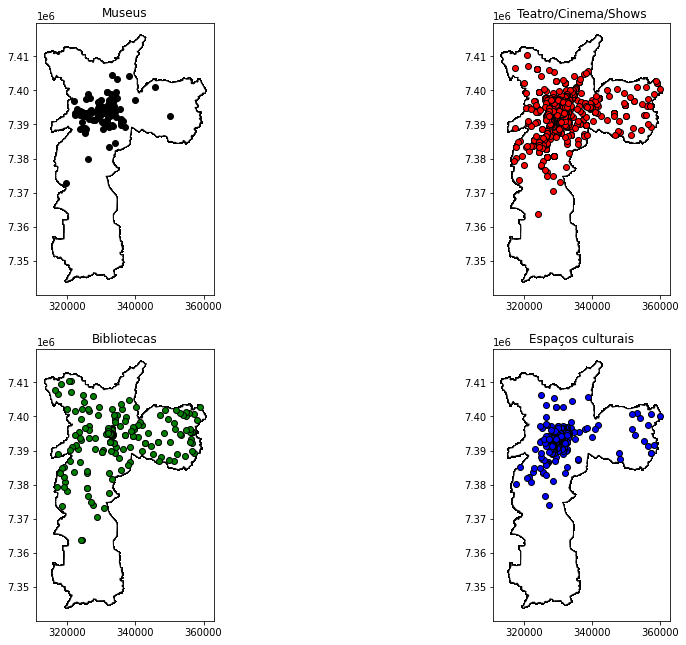

In [ ]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(15, 11))

muni_museus.plot(ax = axs[0][0],facecolor='white', edgecolor='black')
museus.plot(ax = axs[0][0], color='black', edgecolor='k')
axs[0][0].set_title('Museus')

muni_tcs.plot(ax = axs[0][1],facecolor='white', edgecolor='black')
tcs.plot(ax = axs[0][1], color='red', edgecolor='k')
axs[0][1].set_title('Teatro/Cinema/Shows')

muni_bibliotecas.plot(ax = axs[1][0],facecolor='white', edgecolor='black')
bibliotecas.plot(ax = axs[1][0], color='green', edgecolor='k')
axs[1][0].set_title('Bibliotecas')

muni_esp_culturais.plot(ax = axs[1][1],facecolor='white', edgecolor='black')
esp_culturais.plot(ax = axs[1][1], color='blue', edgecolor='k')
axs[1][1].set_title('Espaços culturais')

plt.show()

### Análise de pontos

##### Criando objetos do tipo PointPattern para análise

Classe que contém atributos de cada espaço analisado. 

In [ ]:
class Espaco:
  def __init__(self, name, points, color):
    self.name = name
    self.points = points
    self.color = color
  
    x = self.points['geometry'].x
    y = self.points['geometry'].y

    self.pontos = np.vstack((x,y)).T
    self.pp = PointPattern(self.pontos)

    self.mc = mean_center(self.pp.points)

    self.std = std_distance(self.pp.points)

Inicializando cada objeto. Ao inicializar, já é criado um atributo do tipo PointPattern. São calculados também o centro médio e a distância padrão

In [ ]:
esp_museus = Espaco('Museus', museus, 'black')
esp_tcs = Espaco('Teatro/Cinema/Show', tcs, 'red')
esp_bibliotecas = Espaco('Bibliotecas', bibliotecas, 'green')
esp_esp_culturais = Espaco('Espaços culturais', esp_culturais, 'blue')

#### a)Centro médio

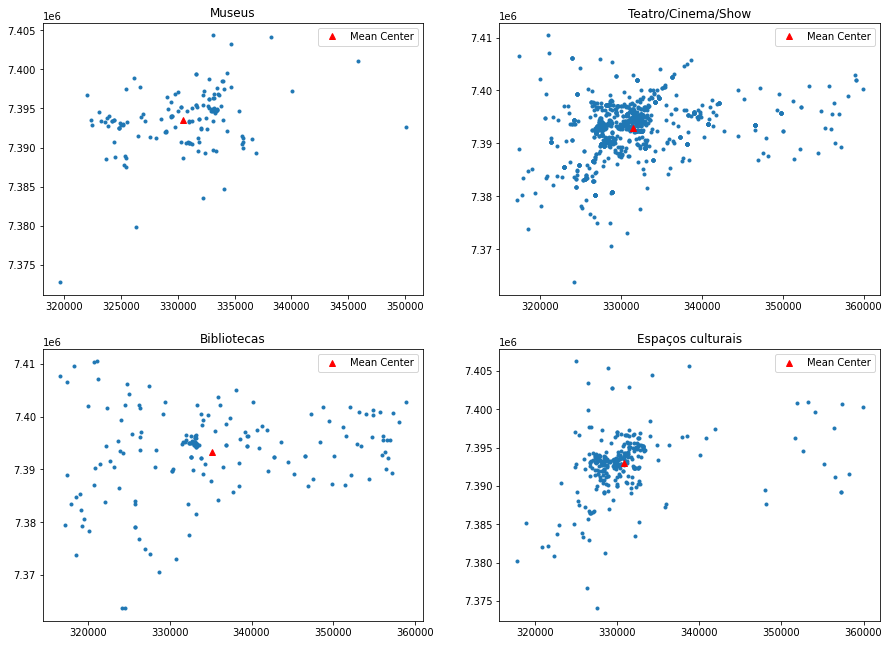

In [ ]:
espacos = [esp_museus, esp_tcs, esp_bibliotecas, esp_esp_culturais]

fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(15, 11))
j = 0
for i in itertools.product([0,1],repeat=2):
  espaco = espacos[j]
  pp = espaco.pp
  mc = espaco.mc
  axs[i[0], i[1]].plot(pp.df[pp._x], pp.df[pp._y], '.')  #Documentação da classe PointPattern
  axs[i[0], i[1]].plot(mc[0],mc[1], 'r^', label='Mean Center')
  axs[i[0], i[1]].legend()
  axs[i[0], i[1]].set_title(espaco.name)
  j += 1

plt.show()

#### b)Círculo de distância padrão

In [ ]:
for espaco in espacos:
  print('Distância padrão {}: {}'.format(espaco.name, espaco.std))

Distância padrão Museus: 6013.938569810965
Distância padrão Teatro/Cinema/Show: 8000.005341337328
Distância padrão Bibliotecas: 13844.584888657462
Distância padrão Espaços culturais: 7192.230957756014


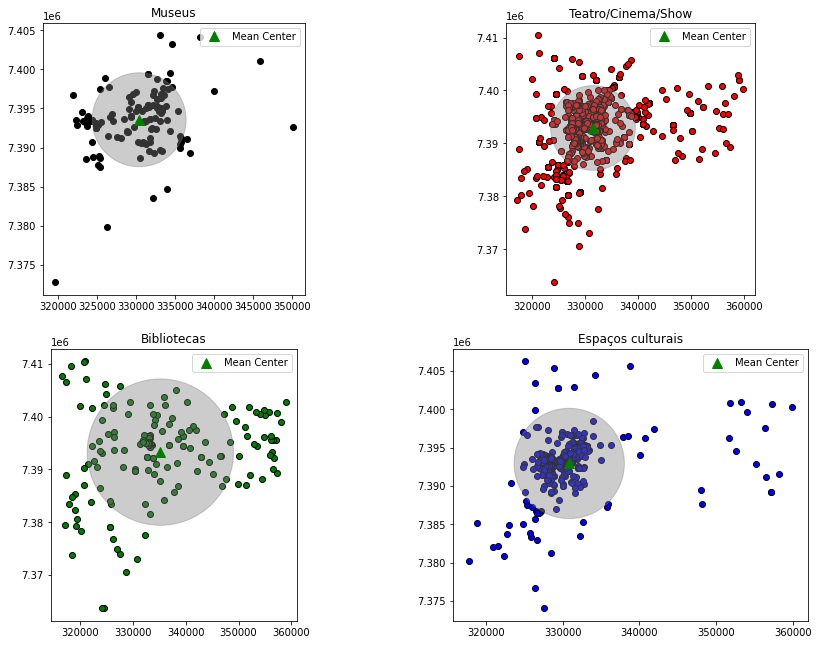

In [ ]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(15, 11))

j = 0
for i in itertools.product([0,1],repeat=2):
  espaco = espacos[j]
  mc = espaco.mc
  std = espaco.std
  espaco.points.plot(ax = axs[i[0]][i[1]], color=espaco.color, edgecolor='k')
  axs[i[0], i[1]].plot(mc[0], mc[1], 'g^', label='Mean Center', markersize=10)
  circle = plt.Circle((mc[0], mc[1]),std,color='gray', alpha = 0.4) 
  axs[i[0], i[1]].add_artist(circle)
  axs[i[0], i[1]].legend()
  axs[i[0], i[1]].set_title(espaco.name)
  j += 1 
plt.show()

#### c)Elipse de distância padrão

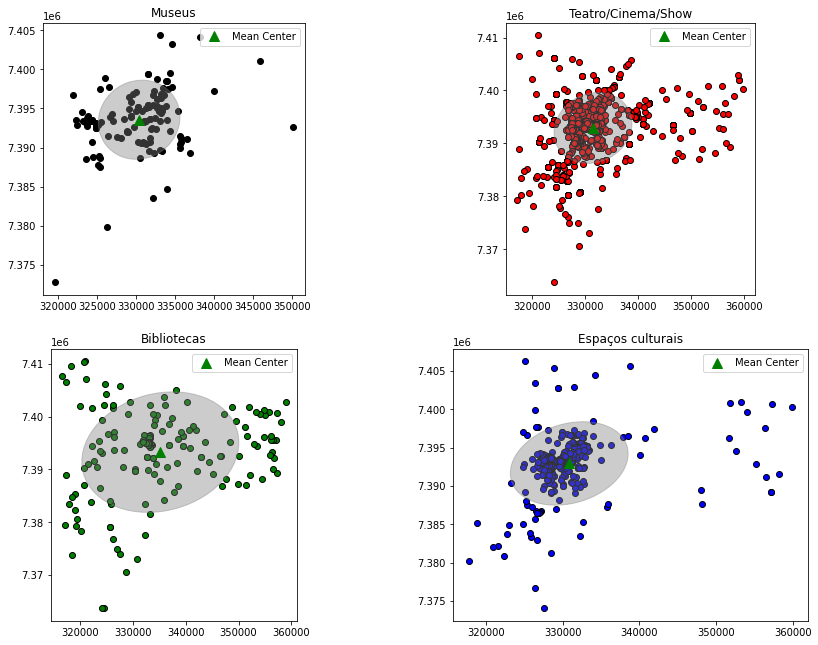

In [ ]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(15, 11))

j = 0
for i in itertools.product([0,1],repeat=2):
  espaco = espacos[j]
  mc = espaco.mc
  std = espaco.std
  pp = espaco.pp

  sx, sy, theta = ellipse(pp.points)
  theta_degree = np.degrees(theta)
  elipse = Ellipse(xy=mean_center(pp.points), width=sx*2, height=sy*2, angle = -theta_degree, color='grey', alpha = 0.4)

  espaco.points.plot(ax = axs[i[0]][i[1]], color=espaco.color, edgecolor='k')
  axs[i[0], i[1]].plot(mc[0], mc[1], 'g^', label='Mean Center', markersize=10)
  axs[i[0], i[1]].add_artist(elipse)
  axs[i[0], i[1]].legend()
  axs[i[0], i[1]].set_title(espaco.name)
  j += 1
plt.show()

#### d)Quadrats

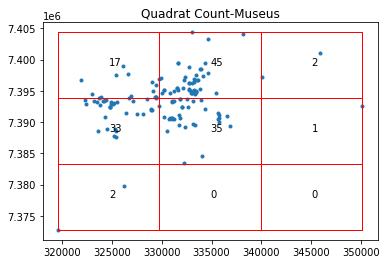

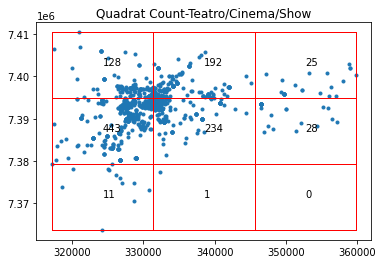

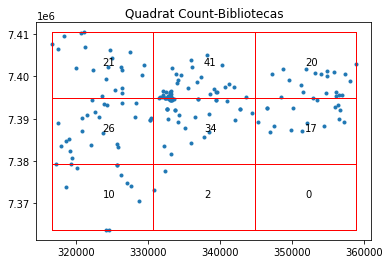

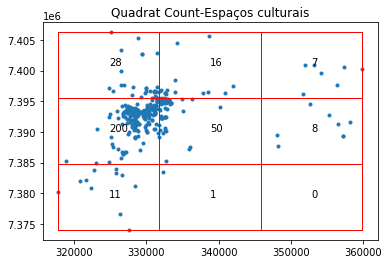

In [ ]:
for espaco in espacos:
  pp = espaco.pp
  q_r = qs.QStatistic(pp, shape='rectangle', nx=3, ny=3)
  q_r.chi2
  q_r.chi2_pvalue
  q_r.plot(title='Quadrat Count-{}'.format(espaco.name))  

#### e)Mapa de kernel

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

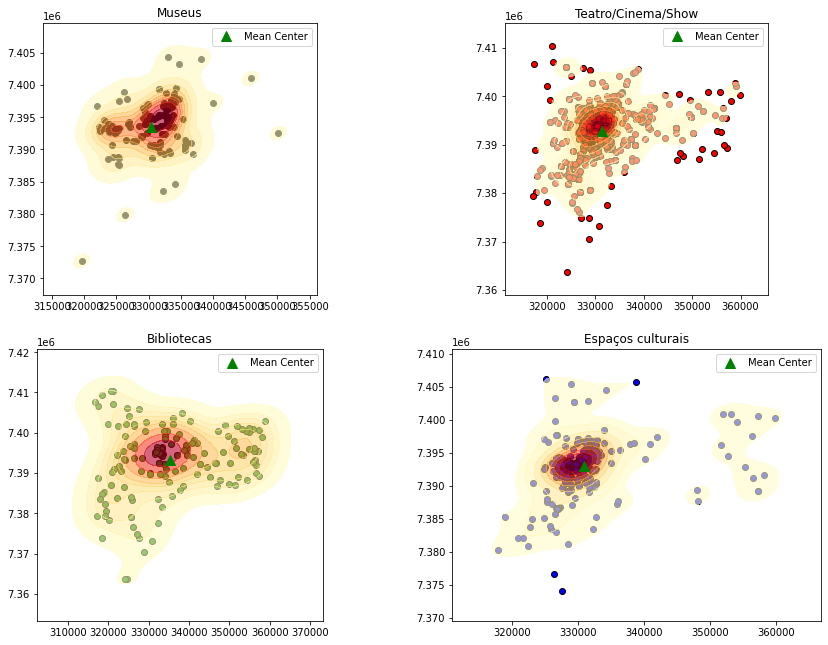

In [ ]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(15, 11))

j = 0
for i in itertools.product([0,1],repeat=2):
  espaco = espacos[j]
  mc = espaco.mc

  espaco.points.plot(ax = axs[i[0]][i[1]], color=espaco.color, edgecolor='k')
  axs[i[0], i[1]].plot(mc[0], mc[1], 'g^', label='Mean Center', markersize=10)
  sns.kdeplot(espaco.pontos[:,0], espaco.pontos[:,1], shade=True, cmap='YlOrRd', ax= axs[i[0]][i[1]], alpha=0.6)
  axs[i[0], i[1]].legend()
  axs[i[0], i[1]].set_title(espaco.name)
  j += 1
plt.show()

#### f)Convex hull

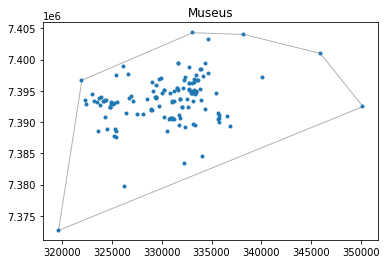

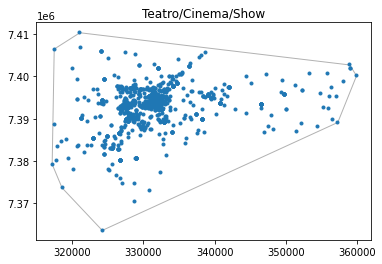

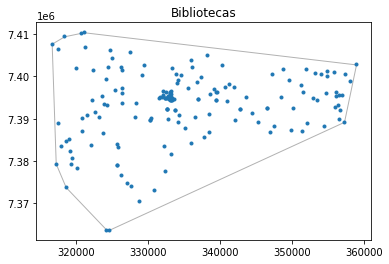

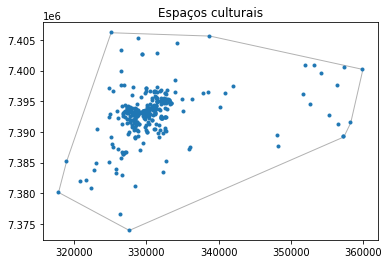

In [ ]:
for espaco in espacos:
  pp = espaco.pp
  pontos = espaco.pontos
  convex_hull_vertices = hull(pontos)
  pp.plot(title = espaco.name, hull=True)

#### g)Distância média (k-nn)

In [ ]:
for espaco in espacos:
  pp = espaco.pp
  area = pp.window.area
  perimetro = pp.window.perimeter
  n = len(espaco.points)

  obtido = pp.mean_nnd
  expected_nnd = 0.5*math.sqrt(area / n) + (0.0514 + 0.041/math.sqrt(n))*(perimetro/n)
  NNI = obtido / expected_nnd
  print(espaco.name)
  print('Valor médio esperado:',expected_nnd)
  print('Valor médio obtido:', obtido)
  print('Nearest Neighbour Index:', NNI, '\n')

Museus
Valor médio esperado: 1387.2233488719214
Valor médio obtido: 756.6116815506631
Nearest Neighbour Index: 0.545414465641696 

Teatro/Cinema/Show
Valor médio esperado: 694.4585636718741
Valor médio obtido: 227.15902492265963
Nearest Neighbour Index: 0.32710234534596416 

Bibliotecas
Valor médio esperado: 1758.7030848866189
Valor médio obtido: 1179.6136665182646
Nearest Neighbour Index: 0.6707292871976241 

Espaços culturais
Valor médio esperado: 1052.9910458841136
Valor médio obtido: 454.5242077414675
Nearest Neighbour Index: 0.4316505914443359 



#### h)Função K de Ripley(250 simulações)

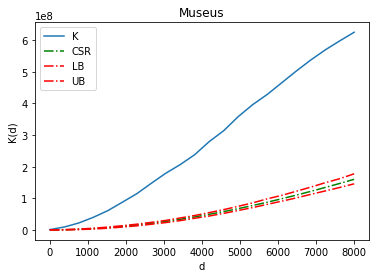

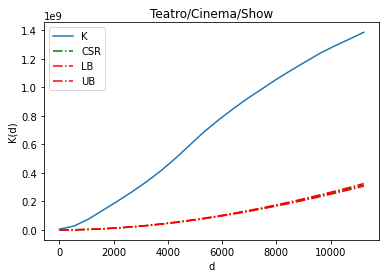

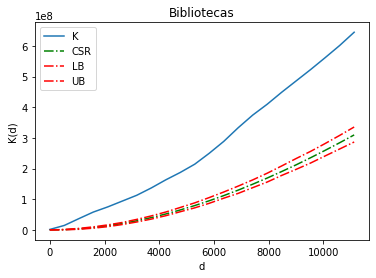

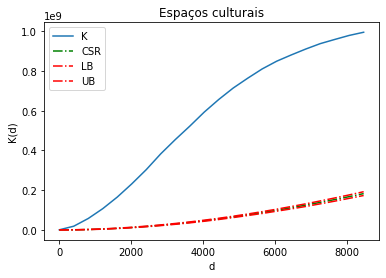

In [ ]:
for espaco in espacos:
  pp = espaco.pp
  realizations = PoissonPointProcess(pp.window, pp.n, 250, asPP = True)
  kenv = Kenv(pp, intervals=20, realizations=realizations)
  kenv.plot()
  plt.title(espaco.name)
  plt.show()